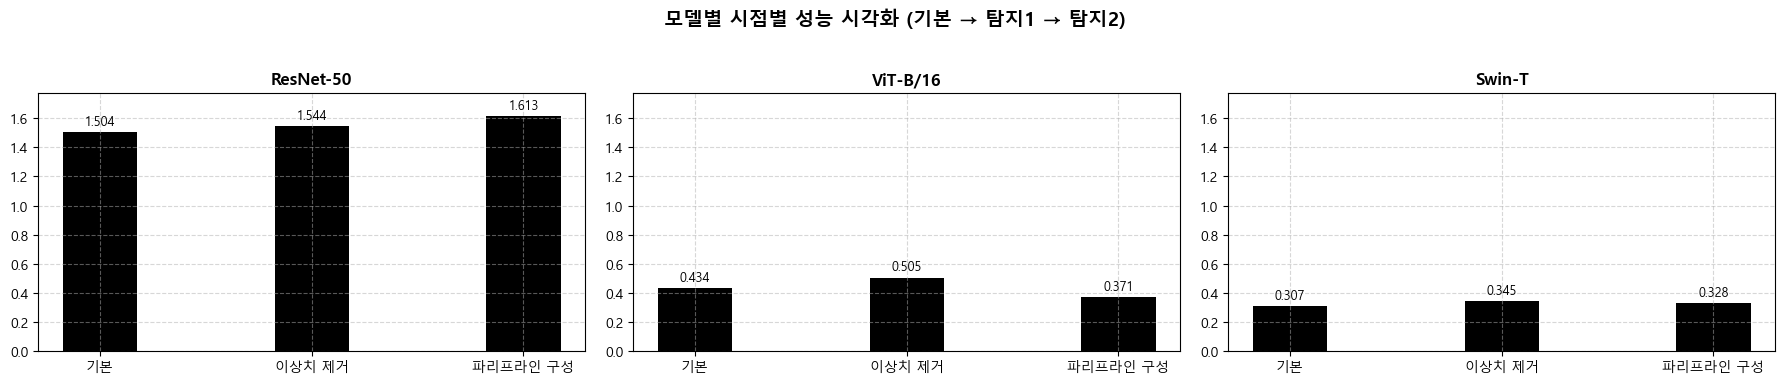

In [14]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


models = ['ResNet-50', 'ViT-B/16', 'Swin-T']
stages = ['기본', '이상치 제거', '파리프라인 구성']

log_loss_data = np.array([
    [1.504, 1.544, 1.613],
    [0.434, 0.505, 0.371], 
    [0.307, 0.345, 0.328]
])

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for idx, ax in zip(range(len(models)), axes):
    x = np.arange(len(stages))
    width = 0.35  # 막대 너비
    
    # Log Loss 막대 그래프
    bars = ax.bar(x, log_loss_data[idx], width, color='black', label='Log Loss')
    
    ax.set_title(models[idx], weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(stages)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # 개선도 계산 및 표시
    improvement = log_loss_data[idx][0] - log_loss_data[idx][-1]  # 처음과 마지막의 차이
    improvement_percent = (improvement / log_loss_data[idx][0]) * 100  # 개선률
    
    # 범례 설정
    # ax.legend(loc='best')
    
    # 값 표시
    # Set y-axis limits to be consistent across all subplots
    ax.set_ylim(0, max(log_loss_data.flatten()) * 1.1)  # Add 10% padding
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=9)  # 폰트 크기 줄임

fig.suptitle('모델별 시점별 성능 시각화 (기본 → 탐지1 → 탐지2)', fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


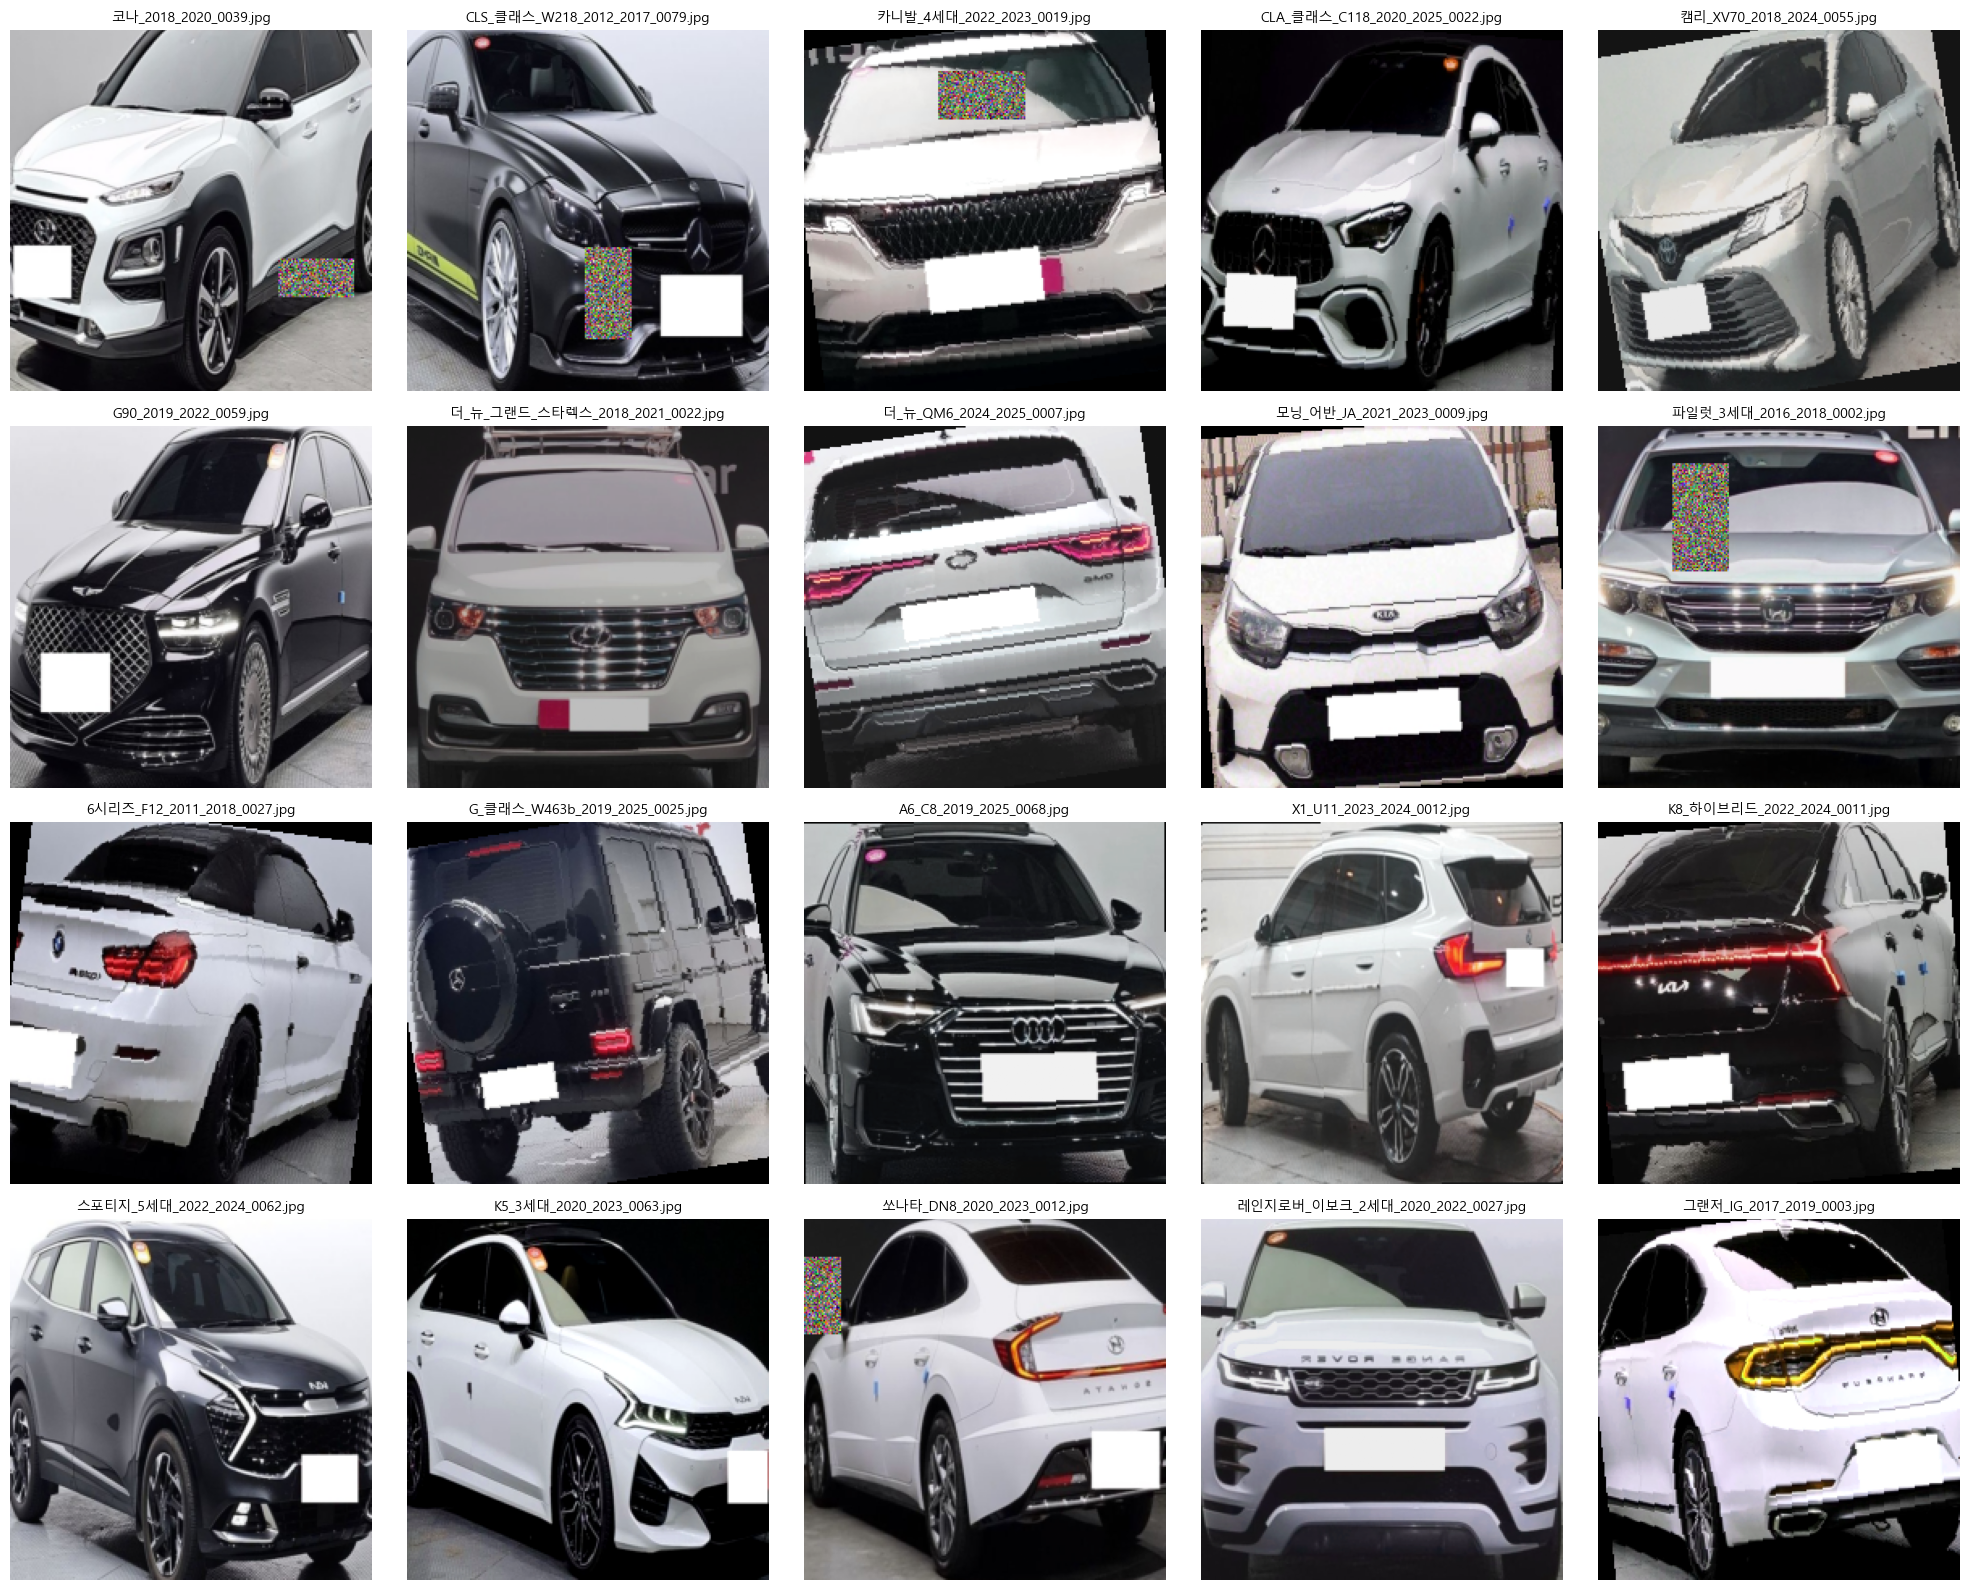

In [4]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# # ✅ 전처리 정의
transform = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 2.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.5),  # 가벼운 회전
            transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.25, scale=(0.01, 0.05), ratio=(0.3, 3.3), value='random')
        ])

# transform = transforms.Compose([
#             transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
#             AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]),
#             transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
#         ])

# ✅ 역정규화 함수
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return tensor * std + mean

# ✅ 이미지 경로 수집
root_dir = '../data/train2'
image_paths = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, fname))

# ✅ 10장 무작위 샘플링
sample_paths = random.sample(image_paths, 20)

# ✅ 시각화
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for idx, img_path in enumerate(sample_paths):
    try:
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img)
        img_tensor_denorm = denormalize(img_tensor.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img_np = img_tensor_denorm.permute(1, 2, 0).detach().cpu().numpy()
        axes[idx].imshow(np.clip(img_np, 0, 1))
        axes[idx].set_title(os.path.basename(img_path), fontsize=10)
        axes[idx].axis('off')
    except Exception as e:
        print(f"이미지 오류 발생: {img_path}\n{e}")

plt.tight_layout()
plt.show()


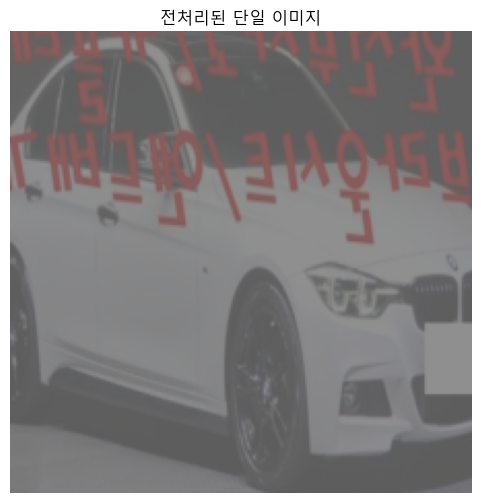

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 전처리 정의
transform = transforms.Compose([
    # transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 2)),
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
])

# ✅ 역정규화 함수
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return tensor * std + mean

# ✅ 이미지 경로 지정 (원하는 파일 경로로 변경)
img_path = '../data/train0/3시리즈_F30_2013_2018/3시리즈_F30_2013_2018_0069.jpg'
try:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    
    # 역정규화 및 시각화용 변환
    img_tensor_denorm = denormalize(img_tensor.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img_np = img_tensor_denorm.permute(1, 2, 0).detach().cpu().numpy()

    # 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(img_np, 0, 1))
    plt.title('전처리된 단일 이미지')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"이미지를 처리하는 중 오류 발생: {e}")


In [1]:
from timm.data import create_transform
transforms = create_transform((3, 224, 224), is_training=True)
print(transforms)

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


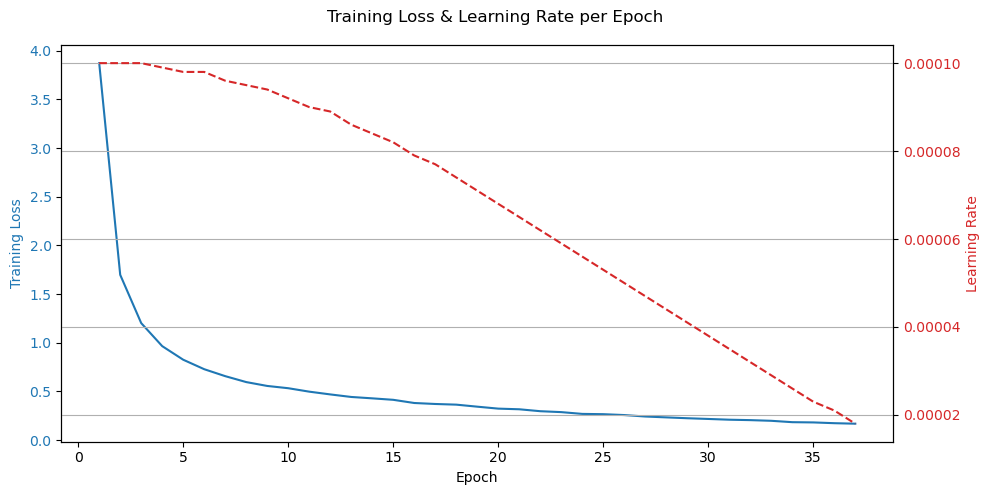

In [4]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = np.array([
    3.8719, 1.6973, 1.2012, 0.9646, 0.8250, 0.7277, 0.6563, 0.5954, 0.5557, 0.5324,
    0.4970, 0.4687, 0.4425, 0.4283, 0.4132, 0.3805, 0.3704, 0.3636, 0.3428, 0.3227,
    0.3160, 0.2962, 0.2868, 0.2685, 0.2656, 0.2566, 0.2417, 0.2328, 0.2240, 0.2166,
    0.2089, 0.2045, 0.1976, 0.1835, 0.1810, 0.1731, 0.1679
])

learning_rate = np.array([
    0.000100, 0.000100, 0.000100, 0.000099, 0.000098, 0.000098, 0.000096, 0.000095, 0.000094,
    0.000092, 0.000090, 0.000089, 0.000086, 0.000084, 0.000082, 0.000079, 0.000077, 0.000074,
    0.000071, 0.000068, 0.000065, 0.000062, 0.000059, 0.000056, 0.000053, 0.000050, 0.000047,
    0.000044, 0.000041, 0.000038, 0.000035, 0.000032, 0.000029, 0.000026, 0.000023, 0.000021,
    0.000018
])

epochs = np.arange(1, len(train_loss) + 1)

# 그래프 생성 (수정된 learning_rate 사용)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Training Loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(epochs, train_loss, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Learning Rate (두 번째 y축)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(epochs, learning_rate, color=color, linestyle='--', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)

# 그래프 제목 및 레이아웃
fig.suptitle('Training Loss & Learning Rate per Epoch')
plt.grid(True)
fig.tight_layout()
plt.show()
